In [11]:
import os
from csv import DictReader as dr
import numpy as np
from scipy.spatial import distance_matrix as dm

In [12]:
def load_data(filepath):
    with open(os.path.join(filepath), "r") as f:
        file = dr(f)
        data = [row for row in file]
    return data

In [13]:
example = load_data("countries.csv")[0]
example

{'': '0',
 'Country': 'Afghanistan ',
 'Population': '31056997',
 'Net migration': '23.06',
 'GDP ($ per capita)': '700.0',
 'Literacy (%)': '36.0',
 'Phones (per 1000)': '3.2',
 'Infant mortality (per 1000 births)': '163.07'}

In [14]:
def calc_features(row):
    array = np.array([row["Population"], row["Net migration"], row["GDP ($ per capita)"], \
                     row["Literacy (%)"], row["Phones (per 1000)"], row["Infant mortality (per 1000 births)"]])
    return array.astype(np.float64)

In [15]:
calc_features(example)

array([3.1056997e+07, 2.3060000e+01, 7.0000000e+02, 3.6000000e+01,
       3.2000000e+00, 1.6307000e+02])

In [5]:
import numpy as np

def hac_single_linkage_with_tiebreaking(data):
    """
    Perform Hierarchical Agglomerative Clustering using single linkage in O(n^2) time,
    with tie-breaking rules for selecting clusters to merge.
    """
    # Number of points
    n = len(data)

    # Initialize each data point as its own cluster
    clusters = [[lamda] for lamda in data]

    # Compute the initial pairwise distance matrix (O(n^2))
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i, j] = np.linalg.norm(data[i] - data[j])
            dist_matrix[j, i] = dist_matrix[i, j]

    # Keep track of which clusters are still active
    active_clusters = list(range(n))

    # Merge history for dendrogram (optional)
    merge_history = []
    
    # Track the size of each cluster (for final output)
    cluster_sizes = np.ones(n)

    while len(active_clusters) > 1:
        # Step 1: Find all pairs of clusters with the smallest distance
        min_dist = np.inf
        candidate_pairs = []

        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                c1, c2 = active_clusters[i], active_clusters[j]
                if dist_matrix[c1, c2] < min_dist:
                    min_dist = dist_matrix[c1, c2]
                    candidate_pairs = [(c1, c2)]  # Reset list with new minimum
                elif dist_matrix[c1, c2] == min_dist:
                    candidate_pairs.append((c1, c2))

        # Step 2: Apply the tie-breaking rule
        # Sort the candidate pairs first by the first index, then by the second index
        candidate_pairs.sort()

        # Select the pair with the smallest first index, and in case of a tie, smallest second index
        c1, c2 = candidate_pairs[0]
        
        # Step 3: Record the merge in the merge history
        merge_history.append((c1, c2, min_dist, cluster_sizes[c1] + cluster_sizes[c2]))

        # Step 4: Merge clusters c1 and c2
        clusters[c1] = clusters[c1] + clusters[c2]
        clusters[c2] = []

        # Step 5: Update the distance matrix using single linkage (min distance)
        for k in active_clusters:
            if k != c1 and k != c2:
                dist_matrix[c1, k] = dist_matrix[k, c1] = min(dist_matrix[c1, k], dist_matrix[c2, k])

        # Mark cluster c2 as inactive by removing it from the active list
        active_clusters.remove(c2)

        # Update the cluster size for c1
        cluster_sizes[c1] += cluster_sizes[c2]

    return [lamda for lamda in clusters if lamda], merge_history

# Example usage
n = 5  # Number of data points
data = np.array([np.random.rand(6) for _ in range(n)])  # Random 6-dimensional data points

final_cluster, history = hac_single_linkage_with_tiebreaking(data)

print("Final Cluster:", final_cluster)
print("Merge History:", history)


Final Cluster: [[array([0.08783849, 0.41762744, 0.74851701, 0.92956592, 0.90217136,
       0.40543778]), array([0.51640348, 0.4977965 , 0.46176914, 0.58856048, 0.99624566,
       0.40373102]), array([0.66601671, 0.62489091, 0.84326075, 0.41313071, 0.45651762,
       0.53820451]), array([0.78448141, 0.48218823, 0.15649487, 0.32094964, 0.58199926,
       0.94729337]), array([0.33848493, 0.99452466, 0.3580574 , 0.05855477, 0.09666712,
       0.27783109])]]
Merge History: [(0, 4, np.float64(0.630441877095413), np.float64(2.0)), (0, 3, np.float64(0.7240428460294065), np.float64(3.0)), (0, 1, np.float64(0.8352496632610402), np.float64(4.0)), (0, 2, np.float64(0.8957339289772271), np.float64(5.0))]


In [9]:
def hac(features):
    n = len(features)
    clusters = [item for item in features]
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))
    
    dismat = dm(features, features)
    print(dismat)
    
    mat = dismat.copy()
    mat[mat == 0] = np.inf
    
    while len(active_clusters) > 1:
        min_value = np.min(mat)
        min_index = np.unravel_index(np.argmin(mat), mat.shape)
        print(min_index)
        to_merge1 = (min_index[0].item(), min_index[1].item())
        to_merge = (min(to_merge1), max(to_merge1)) # it should be (smaller, bigger) now
        
        clusters[to_merge[0]] = clusters[to_merge[0]] + clusters[to_merge[1]]
        clusters[to_merge[1]] = []
    
        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]
    
        #update merge history
        merge_hist.append([to_merge[0], to_merge[1], min_value, cluster_sizes[to_merge[0]]])
        #print(merge_hist)
    
        #update other things and repeat
        mat[to_merge1[0]] = np.zeros(n)
        mat[:, to_merge1[1]] = np.zeros(n)
        mat[mat == 0] = np.inf
        
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])
    
        active_clusters.remove(to_merge[1])

    return merge_hist
        

In [10]:
data = load_data("countries.csv")
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
hac(features)

[[       0.         27475342.26329052  1873101.50488285 ...
   9600809.00115646 19554987.00046377 18820192.03860689]
 [27475342.26329052        0.         29348436.03833987 ...
  17874533.38306165  7920355.86476462  8655150.39075838]
 [ 1873101.50488285 29348436.03833987        0.         ...
  11473904.17845662 21428081.63114098 20693286.40627686]
 ...
 [ 9600809.00115646 17874533.38306165 11473904.17845662 ...
         0.          9954178.00012472  9219383.06571951]
 [19554987.00046377  7920355.86476462 21428081.63114098 ...
   9954178.00012472        0.           734795.82395202]
 [18820192.03860689  8655150.39075838 20693286.40627686 ...
   9219383.06571951   734795.82395202        0.        ]]
(np.int64(141), np.int64(190))
(np.int64(190), np.int64(141))


ValueError: operands could not be broadcast together with shapes (6,) (0,) 

In [16]:
import numpy as np

def hac(features):
    n = len(features)
    clusters = [np.array(item) for item in features]  # Convert each item to a numpy array
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))  # Tracks unmerged clusters
    
    dismat = dm(features, features)  # Assuming dm is your distance matrix function
    print(dismat)
    
    mat = dismat.copy()
    mat[mat == 0] = np.inf  # Set self-distances to infinity
    
    while len(active_clusters) > 1:
        # Find the pair of clusters with the minimum distance
        min_value = np.inf
        to_merge1 = (None, None)
        for i in active_clusters:
            for j in active_clusters:
                if i != j and mat[i, j] < min_value:
                    min_value = mat[i, j]
                    to_merge1 = (i, j)
        
        # Ensure clusters to_merge are (smaller, larger)
        to_merge = (min(to_merge1), max(to_merge1))
        
        # Merge the clusters
        if clusters[to_merge[1]] is not None and clusters[to_merge[0]] is not None:
            clusters[to_merge[0]] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
            clusters[to_merge[1]] = None  # Mark the second cluster as None (or remove it)
            
            cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]
        
            # Update merge history
            merge_hist.append([to_merge[0], to_merge[1], min_value, cluster_sizes[to_merge[0]]])
        
            # Invalidate the second cluster in the distance matrix
            mat[to_merge[1], :] = np.inf  # Invalidate the merged cluster's row
            mat[:, to_merge[1]] = np.inf  # Invalidate the merged cluster's column
        
            # Update the distance matrix for the newly formed cluster
            for k in active_clusters:
                if k != to_merge[0] and clusters[k] is not None:
                    mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])
        
            # Remove the second cluster from active clusters
            active_clusters.remove(to_merge[1])

    return merge_hist

In [17]:
data = load_data("countries.csv")
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
hac(features)

[[       0.         27475342.26329052  1873101.50488285 ...
   9600809.00115646 19554987.00046377 18820192.03860689]
 [27475342.26329052        0.         29348436.03833987 ...
  17874533.38306165  7920355.86476462  8655150.39075838]
 [ 1873101.50488285 29348436.03833987        0.         ...
  11473904.17845662 21428081.63114098 20693286.40627686]
 ...
 [ 9600809.00115646 17874533.38306165 11473904.17845662 ...
         0.          9954178.00012472  9219383.06571951]
 [19554987.00046377  7920355.86476462 21428081.63114098 ...
   9954178.00012472        0.           734795.82395202]
 [18820192.03860689  8655150.39075838 20693286.40627686 ...
   9219383.06571951   734795.82395202        0.        ]]


[[141, 190, np.float64(831.6194248573081), np.float64(2.0)],
 [107, 124, np.float64(2507.5358328247275), np.float64(2.0)],
 [159, 185, np.float64(3236.979537346506), np.float64(2.0)],
 [131, 132, np.float64(4378.690398304041), np.float64(2.0)],
 [155, 158, np.float64(4442.832087891687), np.float64(2.0)],
 [137, 166, np.float64(4789.009216570793), np.float64(2.0)],
 [7, 53, np.float64(5608.867158749617), np.float64(2.0)],
 [17, 66, np.float64(5636.859246610652), np.float64(2.0)],
 [81, 181, np.float64(5902.718735506546), np.float64(2.0)],
 [94, 106, np.float64(6362.6031182684965), np.float64(2.0)],
 [3, 117, np.float64(6920.646084095039), np.float64(2.0)],
 [6, 141, np.float64(7114.532819813258), np.float64(3.0)],
 [25, 68, np.float64(7502.741325575606), np.float64(2.0)],
 [1, 108, np.float64(8105.835508773911), np.float64(2.0)],
 [4, 7, np.float64(8269.45870783572), np.float64(3.0)],
 [157, 160, np.float64(8455.523727913016), np.float64(2.0)],
 [6, 155, np.float64(8540.406184046517), n

In [18]:
import numpy as np

def hac_with_tiebreaking(features):
    n = len(features)
    clusters = [np.array(item) for item in features]  # Convert each item to a numpy array
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))  # Tracks unmerged clusters
    
    # Initialize the distance matrix (assuming a distance function like Euclidean)
    dismat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dismat[i, j] = np.linalg.norm(features[i] - features[j])
            dismat[j, i] = dismat[i, j]

    # Set self-distances to infinity
    mat = dismat.copy()
    np.fill_diagonal(mat, np.inf)
    
    while len(active_clusters) > 1:
        # Step 1: Find the minimum distance among active clusters
        min_dist = np.inf
        candidate_pairs = []

        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                c1, c2 = active_clusters[i], active_clusters[j]
                if mat[c1, c2] < min_dist:
                    min_dist = mat[c1, c2]
                    candidate_pairs = [(c1, c2)]  # Reset list with new minimum
                elif mat[c1, c2] == min_dist:
                    candidate_pairs.append((c1, c2))  # Add to candidates if equal distance
        
        # Step 2: Tie-breaking by selecting the lexicographically smallest pair
        candidate_pairs.sort()
        to_merge = candidate_pairs[0]  # Select the first pair after sorting
        
        # Ensure the pair is (smaller, larger)
        to_merge = (min(to_merge), max(to_merge))

        # Step 3: Merge the clusters
        clusters[to_merge[0]] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
        clusters[to_merge[1]] = None  # Mark the second cluster as None (or remove it)
        
        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]

        # Step 4: Record the merge history
        if cluster_sizes[to_merge[0]] > 1 or cluster_sizes(to_merge[1] > 1):
            merge_hist.append([to_merge[0] + n, to_merge[1] + n, min_dist, cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]])
        else:
            merge_hist.append([n + o, to_merge[1], min_dist, cluster_sizes[to_merge[0]]])

        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]
        
        # Step 5: Update the distance matrix (single linkage: minimum distance)
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])

        # Step 6: Mark cluster to_merge[1] as inactive and remove it from active_clusters
        mat[to_merge[1], :] = np.inf  # Invalidate row for merged cluster
        mat[:, to_merge[1]] = np.inf  # Invalidate column for merged cluster
        active_clusters.remove(to_merge[1])  # Remove the merged cluster from active clusters
    
    return np.array(merge_hist)

In [19]:
data = load_data("countries.csv")
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
hac_with_tiebreaking(features)

array([[3.45000000e+02, 3.94000000e+02, 8.31619425e+02, 3.00000000e+00],
       [3.11000000e+02, 3.28000000e+02, 2.50753583e+03, 3.00000000e+00],
       [3.63000000e+02, 3.89000000e+02, 3.23697954e+03, 3.00000000e+00],
       [3.35000000e+02, 3.36000000e+02, 4.37869040e+03, 3.00000000e+00],
       [3.59000000e+02, 3.62000000e+02, 4.44283209e+03, 3.00000000e+00],
       [3.41000000e+02, 3.70000000e+02, 4.78900922e+03, 3.00000000e+00],
       [2.11000000e+02, 2.57000000e+02, 5.60886716e+03, 3.00000000e+00],
       [2.21000000e+02, 2.70000000e+02, 5.63685925e+03, 3.00000000e+00],
       [2.85000000e+02, 3.85000000e+02, 5.90271874e+03, 3.00000000e+00],
       [2.98000000e+02, 3.10000000e+02, 6.36260312e+03, 3.00000000e+00],
       [2.10000000e+02, 3.59000000e+02, 6.67500271e+03, 7.00000000e+00],
       [3.26000000e+02, 3.63000000e+02, 6.68807578e+03, 7.00000000e+00],
       [2.31000000e+02, 3.45000000e+02, 6.69351130e+03, 7.00000000e+00],
       [2.07000000e+02, 3.21000000e+02, 6.92064608e

In [45]:
#previous verison:
def hac(features):
    n = len(features)
    clusters = [np.array(item) for item in features]  # Convert each item to a numpy array
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))  # Tracks unmerged clusters
    
    # Initialize the distance matrix (assuming a distance function like Euclidean)
    dismat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dismat[i, j] = np.linalg.norm(features[i] - features[j])
            dismat[j, i] = dismat[i, j]

    # Set self-distances to infinity
    mat = dismat.copy()
    np.fill_diagonal(mat, np.inf)

    while len(active_clusters) > 1:
        # Step 1: Find the minimum distance among active clusters
        min_dist = np.inf
        candidate_pairs = []

        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                c1, c2 = active_clusters[i], active_clusters[j]
                if mat[c1, c2] < min_dist:
                    min_dist = mat[c1, c2]
                    candidate_pairs = [(c1, c2)]  # Reset list with new minimum
                elif mat[c1, c2] == min_dist:
                    candidate_pairs.append((c1, c2))  # Add to candidates if equal distance
        
        # Step 2: Tie-breaking by selecting the lexicographically smallest pair
        candidate_pairs.sort()
        to_merge = candidate_pairs[0]  # Select the first pair after sorting
        
        # Ensure the pair is (smaller, larger)
        to_merge = (min(to_merge), max(to_merge))

        # Step 3: Merge the clusters
        clusters[to_merge[0]] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
        clusters[to_merge[1]] = None  # Mark the second cluster as None (or remove it)
        
        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]

        # Step 4: Record the merge history
        merge_hist.append([to_merge[0], to_merge[1], min_dist, cluster_sizes[to_merge[0]]])
        
        # Step 5: Update the distance matrix (single linkage: minimum distance)
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])

        # Step 6: Mark cluster to_merge[1] as inactive and remove it from active_clusters
        mat[to_merge[1], :] = np.inf  # Invalidate row for merged cluster
        mat[:, to_merge[1]] = np.inf  # Invalidate column for merged cluster
        active_clusters.remove(to_merge[1])  # Remove the merged cluster from active clusters
        
    return np.array(merge_hist)

In [49]:
def hac(features):
    n = len(features)
    clusters = [np.array(item) for item in features]  # Convert each item to a numpy array
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))  # Tracks unmerged clusters
    
    # Initialize the distance matrix (assuming a distance function like Euclidean)
    dismat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dismat[i, j] = np.linalg.norm(features[i] - features[j])
            dismat[j, i] = dismat[i, j]

    # Set self-distances to infinity
    mat = dismat.copy()
    np.fill_diagonal(mat, np.inf)

    while len(active_clusters) > 1:
        # Step 1: Find the minimum distance among active clusters
        min_dist = np.inf
        candidate_pairs = []

        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                c1, c2 = active_clusters[i], active_clusters[j]
                if mat[c1, c2] < min_dist:
                    min_dist = mat[c1, c2]
                    candidate_pairs = [(c1, c2)]  # Reset list with new minimum
                elif mat[c1, c2] == min_dist:
                    candidate_pairs.append((c1, c2))  # Add to candidates if equal distance
        
        # Step 2: Tie-breaking by selecting the lexicographically smallest pair
        candidate_pairs.sort()
        to_merge = candidate_pairs[0]  # Select the first pair after sorting
        
        # Ensure the pair is (smaller, larger)
        to_merge = (min(to_merge), max(to_merge))

        # Step 3: Merge the clusters
        clusters[to_merge[0]] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
        clusters[to_merge[1]] = None  # Mark the second cluster as None (or remove it)
        
        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]

        # Step 4: Record the merge history
        if cluster_sizes[to_merge[0]] > 1:
            if cluster_sizes[to_merge[1]] > 1:
                merge_hist.append([n + cluster_sizes[to_merge[0]] -1, n + cluster_sizes[to_merge[1]] -1, min_dist, cluster_sizes[to_merge[0]]])
            else:
                merge_hist.append([n + cluster_sizes[to_merge[0]] -1, to_merge[1], min_dist, cluster_sizes[to_merge[0]]])
        elif cluster_sizes[to_merge[0]] > 1:
            merge_hist.append([to_merge[0], n + cluster_sizes[to_merge[1]] -1, min_dist, cluster_sizes[to_merge[0]]])
        else:
            merge_hist.append([to_merge[0], to_merge[1], min_dist, cluster_sizes[to_merge[0]]])
        
        # Step 5: Update the distance matrix (single linkage: minimum distance)
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])

        # Step 6: Mark cluster to_merge[1] as inactive and remove it from active_clusters
        mat[to_merge[1], :] = np.inf  # Invalidate row for merged cluster
        mat[:, to_merge[1]] = np.inf  # Invalidate column for merged cluster
        active_clusters.remove(to_merge[1])  # Remove the merged cluster from active clusters
        
    return np.array(merge_hist)

In [ ]:
def hac(features):
    n = len(features)
    clusters = [np.array(item) for item in features]  # Convert each item to a numpy array
    merge_hist = []
    cluster_sizes = np.ones(n)
    active_clusters = list(range(n))  # Tracks unmerged clusters
    
    # Initialize the distance matrix (assuming a distance function like Euclidean)
    dismat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dismat[i, j] = np.linalg.norm(features[i] - features[j])
            dismat[j, i] = dismat[i, j]

    # Set self-distances to infinity
    mat = dismat.copy()
    np.fill_diagonal(mat, np.inf)

    while len(active_clusters) > 1:
        # Step 1: Find the minimum distance among active clusters
        min_dist = np.inf
        candidate_pairs = []

        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                c1, c2 = active_clusters[i], active_clusters[j]
                if mat[c1, c2] < min_dist:
                    min_dist = mat[c1, c2]
                    candidate_pairs = [(c1, c2)]  # Reset list with new minimum
                elif mat[c1, c2] == min_dist:
                    candidate_pairs.append((c1, c2))  # Add to candidates if equal distance
        
        # Step 2: Tie-breaking by selecting the lexicographically smallest pair
        candidate_pairs.sort()
        to_merge = candidate_pairs[0]  # Select the first pair after sorting
        
        # Ensure the pair is (smaller, larger)
        to_merge = (min(to_merge), max(to_merge))

        # Step 3: Merge the clusters
        clusters[to_merge[0]] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
        clusters[to_merge[1]] = None  # Mark the second cluster as None (or remove it)
        
        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]

        # Step 4: Record the merge history
        if cluster_sizes[to_merge[0]] > 1:
            if cluster_sizes[to_merge[1]] > 1:
                merge_hist.append([n + cluster_sizes[to_merge[0]] -1, n + cluster_sizes[to_merge[1]] -1, min_dist, cluster_sizes[to_merge[0]]])
            else:
                merge_hist.append([n + cluster_sizes[to_merge[0]] -1, to_merge[1], min_dist, cluster_sizes[to_merge[0]]])
        elif cluster_sizes[to_merge[0]] > 1:
            merge_hist.append([to_merge[0], n + cluster_sizes[to_merge[1]] -1, min_dist, cluster_sizes[to_merge[0]]])
        else:
            merge_hist.append([to_merge[0], to_merge[1], min_dist, cluster_sizes[to_merge[0]]])
        
        # Step 5: Update the distance matrix (single linkage: minimum distance)
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                mat[to_merge[0], k] = mat[k, to_merge[0]] = min(mat[to_merge[0], k], mat[to_merge[1], k])

        # Step 6: Mark cluster to_merge[1] as inactive and remove it from active_clusters
        mat[to_merge[1], :] = np.inf  # Invalidate row for merged cluster
        mat[:, to_merge[1]] = np.inf  # Invalidate column for merged cluster
        active_clusters.remove(to_merge[1])  # Remove the merged cluster from active clusters
        
    return np.array(merge_hist)

In [ ]:
#this one was right on all of them except the last row's indices
if cluster_sizes[to_merge[0]] > 1:
            if cluster_sizes[to_merge[1]] > 1:
                revise = [n + cluster_sizes[to_merge[0]] -2, n + cluster_sizes[to_merge[1]] -2]
                merge_hist.append([min(revise), max(revise), min_dist, cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]])
            else:
                revise = [n + cluster_sizes[to_merge[0]] -2, to_merge[1]]
                merge_hist.append([min(revise), max(revise), min_dist, cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]])
        elif cluster_sizes[to_merge[1]] > 1:
            revise = [to_merge[0], n + cluster_sizes[to_merge[1]] -2]
            merge_hist.append([min(revise), max(revise), min_dist, cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]])
        else:
            merge_hist.append([to_merge[0], to_merge[1], min_dist, cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]])

        cluster_sizes[to_merge[0]] += cluster_sizes[to_merge[1]]
        

In [64]:
#chatgpt's verison

def hac(features):
    n = len(features)
    merge_hist = np.zeros((n-1, 4))

    # Initialize cluster sizes (each cluster initially has size 1)
    cluster_sizes = {}
    for i in range(n):
        cluster_sizes[i] = 1

    active_clusters = set(range(n))
    
    # Step 1: Initialize the distance matrix
    distance_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i+1, n):
            distance_matrix[i, j] = np.linalg.norm(features[i] - features[j])
            distance_matrix[j, i] = distance_matrix[i, j]
    
    # Step 2: Iteratively merge clusters
    for k in range(n-1):
        # Step 2a: Find the pair of clusters with the smallest distance
        min_dist = np.inf
        i_min, j_min = -1, -1
        
        for i in active_clusters:
            for j in active_clusters:
                if i < j:  # Only consider i < j to avoid duplicate pairs
                    distance = distance_matrix[i, j]
                    if (distance < min_dist or (distance == min_dist and i < i_min) or (distance == min_dist and i == i_min and j < j_min)):
                        min_dist = distance
                        i_min, j_min = i, j
        
        # Step 2b: Merge the two closest clusters
        merge_hist[k, 0] = min(i_min, j_min)
        merge_hist[k, 1] = max(i_min, j_min)
        merge_hist[k, 2] = min_dist
        merge_hist[k, 3] = cluster_sizes[i_min] + cluster_sizes[j_min]
        
        # Step 3: Update the distance matrix with the new cluster
        new_cluster_index = n + k  # Index for the new cluster
        
        # Temporary dictionary to hold the new distances
        new_distances = {}
        for i in active_clusters:
            if i != i_min and i != j_min:
                new_distances[i] = min(distance_matrix[i, i_min], distance_matrix[i, j_min])
        
        # Step 4: Update the cluster information
        # Remove the old clusters from active clusters
        active_clusters.remove(i_min)
        active_clusters.remove(j_min)
        
        # Add the new cluster
        active_clusters.add(new_cluster_index)
        
        # Update the distance matrix (dynamic tracking using a dictionary)
        distance_matrix = np.vstack([distance_matrix, np.inf * np.ones(n+k)])  # Add a new row
        distance_matrix = np.hstack([distance_matrix, np.inf * np.ones((n+k+1, 1))])  # Add a new column
        
        # Set the new distances in the matrix
        for i in new_distances:
            distance_matrix[i, new_cluster_index] = new_distances[i]
            distance_matrix[new_cluster_index, i] = new_distances[i]
        
        # Update the size of the new cluster
        cluster_sizes[new_cluster_index] = cluster_sizes[i_min] + cluster_sizes[j_min]
    
    return merge_hist


In [65]:
hac(features[:10])

array([[4.00000000e+00, 7.00000000e+00, 8.26945871e+03, 2.00000000e+00],
       [3.00000000e+00, 1.00000000e+01, 1.17085997e+04, 3.00000000e+00],
       [6.00000000e+00, 1.10000000e+01, 4.43215277e+04, 4.00000000e+00],
       [1.00000000e+00, 9.00000000e+00, 6.05283839e+05, 2.00000000e+00],
       [0.00000000e+00, 2.00000000e+00, 1.87310150e+06, 2.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.90521236e+06, 6.00000000e+00],
       [8.00000000e+00, 1.40000000e+01, 6.99174394e+06, 3.00000000e+00],
       [5.00000000e+00, 1.50000000e+01, 8.54541640e+06, 7.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.89299260e+07, 1.00000000e+01]])

In [20]:
# my version via chatgpt correction
import numpy as np

def hac(features):
    n = len(features)
    clusters = {i: np.array(features[i]) for i in range(n)}  # Convert each item to a numpy array, stored in a dictionary
    merge_hist = []
    cluster_sizes = {i: 1 for i in range(n)}
    active_clusters = set(range(n))  # Tracks unmerged clusters
    
    # Initialize the distance matrix (assuming a distance function like Euclidean)
    dismat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dismat[i, j] = np.linalg.norm(features[i] - features[j])
            dismat[j, i] = dismat[i, j]

    # Set self-distances to infinity
    mat = dismat.copy()
    np.fill_diagonal(mat, np.inf)

    cluster_counter = n  # Counter for newly formed clusters
    while len(active_clusters) > 1:
        # Step 1: Find the minimum distance among active clusters
        min_dist = np.inf
        i_min, j_min = None, None


        #need to implement tiebreaking still
        for i in active_clusters:
            for j in active_clusters:
                if i < j:  # Only consider i < j to avoid duplicate pairs
                    distance = mat[i, j]
                    if (distance < min_dist or (distance == min_dist and i < i_min) or (distance == min_dist and i == i_min and j < j_min)):
                        min_dist = distance
                        i_min, j_min = i, j

        if i_min is None or j_min is None:
            break  # No valid pair to merge
        
        # Ensure the pair is (smaller, larger)
        to_merge = (min(i_min, j_min), max(i_min, j_min))
        
        # Step 3: Merge the clusters
        clusters[cluster_counter] = np.concatenate((clusters[to_merge[0]], clusters[to_merge[1]]))  # Merge clusters
        cluster_sizes[cluster_counter] = cluster_sizes[to_merge[0]] + cluster_sizes[to_merge[1]]

        # Step 4: Record the merge history
        merge_hist.append([to_merge[0], to_merge[1], min_dist, cluster_sizes[cluster_counter]])

        # Step 5: Expand the distance matrix for the new cluster
        new_mat = np.zeros((cluster_counter + 1, cluster_counter + 1))
        new_mat[:cluster_counter, :cluster_counter] = mat[:cluster_counter, :cluster_counter]  # Copy old distances
        new_mat[cluster_counter, :] = np.inf  # Initialize new row and column with infinity
        new_mat[:, cluster_counter] = np.inf

        # Step 6: Update the distance matrix (single linkage: minimum distance)
        for k in active_clusters:
            if k != to_merge[0] and k != to_merge[1]:
                new_dist = min(mat[to_merge[0], k], mat[to_merge[1], k])
                new_mat[cluster_counter, k] = new_mat[k, cluster_counter] = new_dist
        
        # Step 7: Mark clusters to_merge[0] and to_merge[1] as inactive and remove them
        active_clusters.remove(to_merge[0])
        active_clusters.remove(to_merge[1])
        active_clusters.add(cluster_counter)

        mat = new_mat  # Update the matrix to the new one
        cluster_counter += 1  # Increment the cluster counter for new clusters
    
    return np.array(merge_hist)


In [62]:
Z = hac(features[-10:])
Z

array([[8.00000000e+00, 9.00000000e+00, 7.34795824e+05, 2.00000000e+00],
       [3.00000000e+00, 5.00000000e+00, 1.57670205e+06, 2.00000000e+00],
       [2.00000000e+00, 4.00000000e+00, 3.22307822e+06, 2.00000000e+00],
       [7.00000000e+00, 1.10000000e+01, 4.27424887e+06, 3.00000000e+00],
       [1.00000000e+01, 1.20000000e+01, 8.07008693e+06, 4.00000000e+00],
       [1.30000000e+01, 1.40000000e+01, 9.21938307e+06, 7.00000000e+00],
       [0.00000000e+00, 6.00000000e+00, 2.37938263e+07, 2.00000000e+00],
       [1.50000000e+01, 1.60000000e+01, 3.33020292e+07, 9.00000000e+00],
       [1.00000000e+00, 1.70000000e+01, 2.14041252e+08, 1.00000000e+01]])

In [67]:
from scipy.cluster.hierarchy import dendrogram as dd
import matplotlib.pyplot as plt

def fig_hac(Z, names):
    dd(Z, labels=names, leaf_rotation = 90, no_plot = False)
    fig= plt.figure()
    return fig

In [ ]:
# PREVOUS VERSION THAT PASSED TESTER
def fig_hac0(Z, names):
    fig= plt.figure()
    ax = fig.add_subplot()
    dd(Z, labels=names, leaf_rotation = 90, ax = ax, no_plot = False)
    return fig

<Figure size 640x480 with 0 Axes>

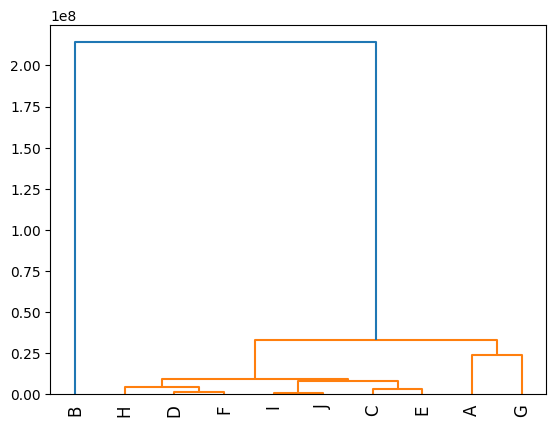

<Figure size 640x480 with 0 Axes>

In [68]:
fig_hac(Z, ["A", "B", "C", "D", "E", "F", "G", "H", "I" , "J"])

<Figure size 640x480 with 0 Axes>

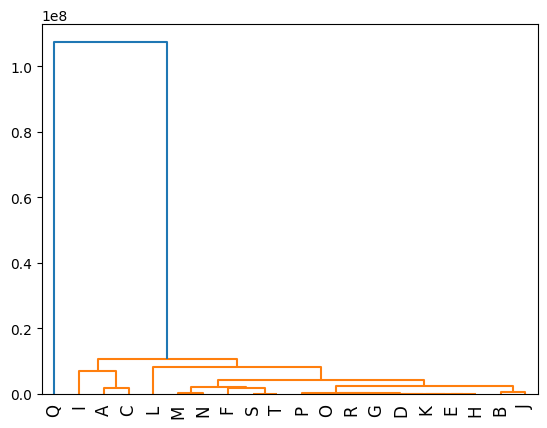

<Figure size 640x480 with 0 Axes>

In [69]:
Z = hac(features[:20])
fig_hac(Z, ["A", "B", "C", "D", "E", "F", "G", "H", "I" , "J", "K", "L", "M", "N", "O", "P","Q","R","S", "T"])

In [47]:
def normalize_features(features):
    means = np.mean(features, axis = 0)
    std = np.std(features, axis = 0)
    mins = np.min(features, axis = 0)
    maxs = np.max(features, axis = 0)

    normalized = (features - mins) / (maxs - mins)
    normal = normalized.tolist()
    return normal

In [52]:
feat = normalize_features(features[-10:])
feat

array([[0.20252557, 0.76218324, 0.72702703, 0.99389002, 0.60159586,
        0.        ],
       [1.        , 1.        , 1.        , 0.95315682, 1.        ,
        0.01611933],
       [0.01080711, 0.27290448, 0.32432432, 0.97352342, 0.31827377,
        0.0816793 ],
       [0.09086202, 0.        , 0.02432432, 1.        , 0.06147449,
        0.79321545],
       [0.        , 0.33528265, 0.05675676, 0.05702648, 0.02742189,
        0.60146758],
       [0.08557526, 0.32748538, 0.10810811, 0.87983707, 0.14823556,
        0.20498015],
       [0.28230757, 0.24756335, 0.04594595, 0.81670061, 0.20173073,
        0.25009022],
       [0.07124346, 0.33528265, 0.        , 0.        , 0.03259159,
        0.67773367],
       [0.03786654, 0.33528265, 0.        , 0.6191446 , 0.        ,
        1.        ],
       [0.04033035, 0.33528265, 0.02972973, 0.82484725, 0.02090357,
        0.75219536]])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

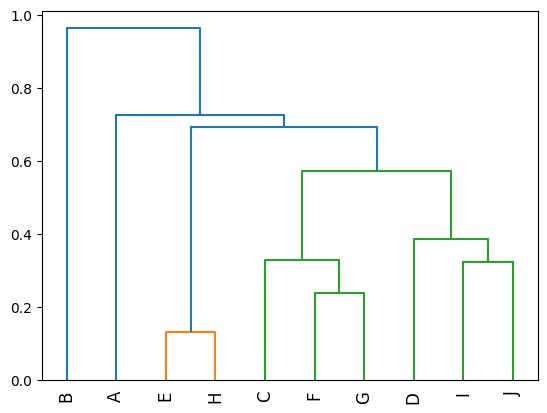

In [53]:
Z = hac(feat)

fig_hac(Z, ["A", "B", "C", "D", "E", "F", "G", "H", "I" , "J"])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

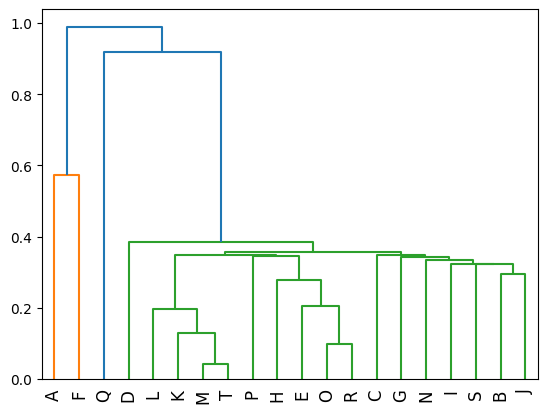

In [55]:
feats = normalize_features(features[:20])
Z = hac(feats)
fig_hac(Z, ["A", "B", "C", "D", "E", "F", "G", "H", "I" , "J", "K", "L", "M", "N", "O", "P","Q","R","S", "T"])